In [1]:
from os import path

# Third-party
import astropy.coordinates as coord
from astropy.table import Table, vstack
from astropy.io import fits
import astropy.units as u
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

from pyia import GaiaData

import gala.coordinates as gc
import gala.dynamics as gd
from scipy.stats import binned_statistic

In [2]:
# plt.style.use('gd1_paper')

In [3]:
t = Table.read('../data/gd1-all-ps1-red.fits')

In [4]:
# deredden
bands = ['g', 'r', 'i', 'z', 'y']
for band in bands:
    t[band] = t[band] - t['A_{}'.format(band)]

In [5]:
g = GaiaData(t)
c = coord.SkyCoord(ra=g.ra, dec=g.dec, pm_ra_cosdec=g.pmra, pm_dec=g.pmdec)

In [88]:
((g.visibility_periods_used[pm_mask & cmd_mask] > 8).sum() / (pm_mask & cmd_mask).sum(),
 np.median(g.visibility_periods_used[pm_mask & cmd_mask]),
 np.std(g.visibility_periods_used[pm_mask & cmd_mask]))

(0.9856338028169014, 14.0, 3.209291657958821)

In [6]:
def gd1_dist(phi1):
    # 0, 10
    # -60, 7
    m = (10-7) / (60)
    return (m*phi1.wrap_at(180*u.deg).value + 10) * u.kpc

In [7]:
gd1_c = c.transform_to(gc.GD1)
gd1_c_noreflex = c.transform_to(gc.GD1)

gd1_c_dist = gc.GD1(phi1=gd1_c.phi1, phi2=gd1_c.phi2,
                    distance=gd1_dist(gd1_c.phi1),
                    pm_phi1_cosphi2=gd1_c.pm_phi1_cosphi2,
                    pm_phi2=gd1_c.pm_phi2,
                    radial_velocity=[0]*len(gd1_c)*u.km/u.s)

# Correct for reflex motion
v_sun = coord.Galactocentric.galcen_v_sun
observed = gd1_c_dist.transform_to(coord.Galactic)
rep = observed.cartesian.without_differentials()
rep = rep.with_differentials(observed.cartesian.differentials['s'] + v_sun)
gd1_c = coord.Galactic(rep).transform_to(gc.GD1)

In [8]:
wangle = 180*u.deg

pm_mask = ((gd1_c.pm_phi1_cosphi2 < -5*u.mas/u.yr) & (gd1_c.pm_phi1_cosphi2 > -10*u.mas/u.yr) & 
           (gd1_c.pm_phi2 < 1*u.mas/u.yr) & (gd1_c.pm_phi2 > -2*u.mas/u.yr) & 
           (g.bp_rp < 1.5*u.mag) & (g.bp_rp > 0*u.mag))

/Users/adrian/anaconda/lib/python3.6/site-packages/astropy/units/quantity.py:639: RuntimeWarning: invalid value encountered in less
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/adrian/anaconda/lib/python3.6/site-packages/astropy/units/quantity.py:639: RuntimeWarning: invalid value encountered in greater
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


In [9]:
phi_mask_stream = ((np.abs(gd1_c.phi2)<1*u.deg) & (gd1_c.phi1.wrap_at(wangle)>-50*u.deg) & 
                   (gd1_c.phi1.wrap_at(wangle)<-10*u.deg))
phi_mask_off = ((gd1_c.phi2<-2*u.deg) & (gd1_c.phi2>-3*u.deg)) | ((gd1_c.phi2<3*u.deg) & (gd1_c.phi2>2*u.deg))

In [10]:
iso = Table.read('../data/mist_12.0_-1.35.cmd', format='ascii.commented_header', header_start=12)
phasecut = (iso['phase']>=0) & (iso['phase']<3)
iso = iso[phasecut]

In [11]:
# distance modulus
distance_app = 7.8*u.kpc
dm = 5*np.log10((distance_app.to(u.pc)).value)-5

# main sequence + rgb
i_gi = iso['PS_g']-iso['PS_i']
i_g = iso['PS_g']+dm

i_left = i_gi - 0.4*(i_g/28)**5
i_right = i_gi + 0.5*(i_g/28)**5

poly = np.hstack([np.array([i_left, i_g]), np.array([i_right[::-1], i_g[::-1]])]).T
ind = (poly[:,1]<21.3) & (poly[:,1]>17.8)
poly_main = poly[ind]

In [12]:
points = np.array([g.g - g.i, g.g]).T
path_main = mpl.path.Path(poly_main)
cmd_mask = path_main.contains_points(points)

pm1_min = -9*u.mas/u.yr
pm1_max = -4.5*u.mas/u.yr
pm2_min = -1.7*u.mas/u.yr
pm2_max = 1.*u.mas/u.yr
pm_mask = ((gd1_c.pm_phi1_cosphi2 < pm1_max) & (gd1_c.pm_phi1_cosphi2 > pm1_min) & 
           (gd1_c.pm_phi2 < pm2_max) & (gd1_c.pm_phi2 > pm2_min))

---

## Stream track

In [13]:
stream_mask = pm_mask & cmd_mask
stream_mask.sum()

3550

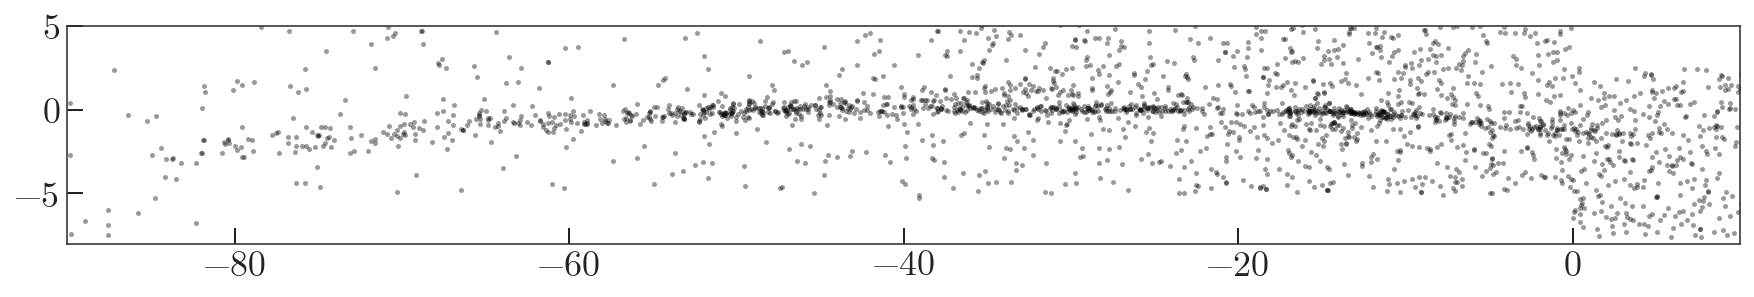

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(15, 2))

ax.plot(gd1_c.phi1.wrap_at(wangle).degree[stream_mask],
        gd1_c.phi2.degree[stream_mask], linestyle='none', alpha=0.4, c='k')

ax.set_xlim(-90, 10)
ax.set_ylim(-8, 5)

ax.set_aspect('equal')

### First, compute the stream track:

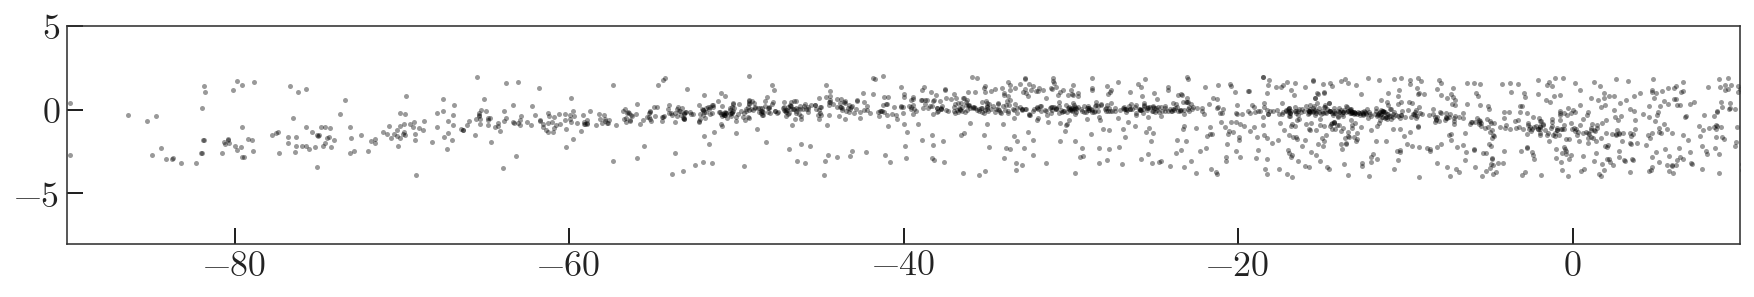

In [15]:
phi2_wide_mask = stream_mask & (gd1_c.phi2 < 2.*u.deg) & (gd1_c.phi2 > -4.*u.deg)

fig, ax = plt.subplots(1, 1, figsize=(15, 2))

ax.plot(gd1_c.phi1.wrap_at(wangle).degree[phi2_wide_mask],
        gd1_c.phi2.degree[phi2_wide_mask], linestyle='none', alpha=0.4, c='k')

ax.set_xlim(-90, 10)
ax.set_ylim(-8, 5)

ax.set_aspect('equal')

In [21]:
bin_size = 4 # deg
bin_l = np.arange(-90, (10-bin_size)+1, 2.)
# bin_size = 8 # deg
# bin_l = np.arange(-85, (10-bin_size)+1, 4)
bin_r = bin_l + bin_size
bin_c = 0.5 * (bin_l+bin_r)
len(bin_r)

49

In [22]:
# bins = np.linspace(-4, 2, 15)

# fig, axes = plt.subplots(6, 6, figsize=(15, 15), sharex=True, sharey=True)
# # fig, axes = plt.subplots(4, 6, figsize=(15, 12), sharex=True, sharey=True)

# _phi1 = gd1_c.phi1[phi2_wide_mask].wrap_at(wangle).degree
# _phi2 = gd1_c.phi2[phi2_wide_mask].degree
# for i, l, r in zip(range(36), bin_l, bin_r):
#     axes.flat[i].hist(_phi2[(_phi1 > l) & (_phi1 <= r)], bins=bins, alpha=1., orientation='horizontal')
#     axes.flat[i].set_title('${0:.1f} < \phi_1 < {1:.1f}$'.format(l, r), fontsize=12)
#     axes.flat[i].axhline(np.median(_phi2[(_phi1 > l) & (_phi1 <= r)]), color='tab:orange')
    
# axes.flat[0].set_xscale('log')
# axes.flat[0].set_xlim(1e0, 1e2)
# fig.tight_layout()

In [23]:
bins_nonoverlap = np.arange(-85, (10-bin_size)+1, bin_size)
cen_phi1 = 0.5 * (bins_nonoverlap[:-1] + bins_nonoverlap[1:])

# median track
phi2_median, be, bn = binned_statistic((gd1_c.phi1[phi2_wide_mask]).wrap_at(wangle).degree, 
                                       gd1_c.phi2[phi2_wide_mask].degree, 
                                       statistic='median', bins=bins_nonoverlap)
phi2_sum, be = np.histogram((gd1_c.phi1[phi2_wide_mask]).wrap_at(wangle).degree, 
                            bins=bins_nonoverlap)
phi2_median_err = np.abs(phi2_median) / np.sqrt(phi2_sum)

In [26]:
deg = 2
ptrack = np.polyfit(cen_phi1, phi2_median, deg, w=1 / np.sqrt(phi2_sum))

polytrack = np.poly1d(ptrack)
phi1_ = np.linspace(-90, 10, 100)
phi2_ = polytrack(phi1_)
# np.savez('../data/gd1_polytrack', p=ptrack)

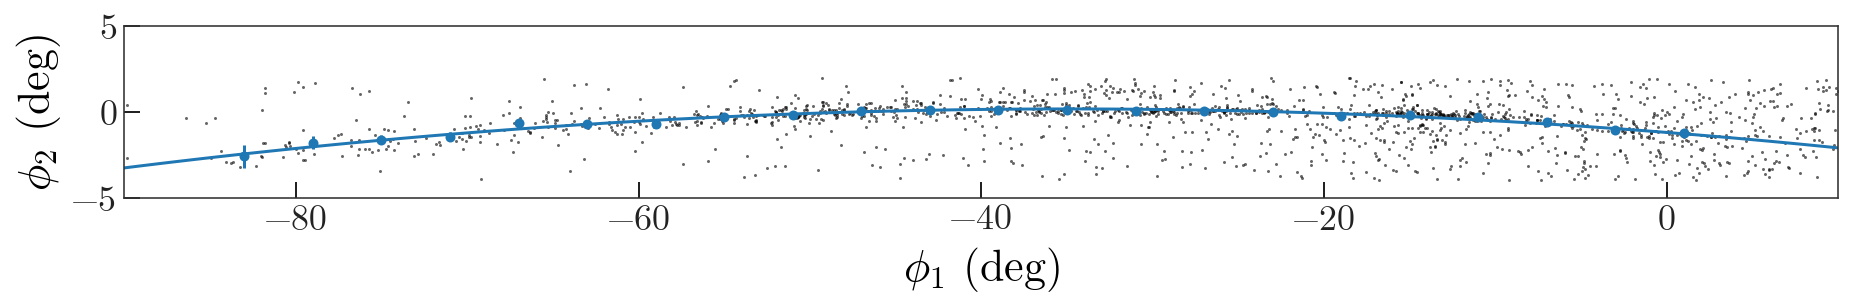

In [27]:
plt.figure(figsize=(13,6))
plt.plot(gd1_c.phi1[phi2_wide_mask].wrap_at(wangle), 
         gd1_c.phi2[phi2_wide_mask], 
         'ko', ms=1.5, alpha=0.6, rasterized=True)
plt.gca().set_aspect('equal')

plt.errorbar(cen_phi1, phi2_median, yerr=phi2_median_err, fmt='o', color='tab:blue')
plt.plot(phi1_, phi2_, '-', color='tab:blue')

plt.xlabel('$\phi_1$ (deg)')
plt.ylabel('$\phi_2$ (deg)')
plt.xlim(-90, 10)
plt.ylim(-5, 5)

plt.tight_layout()

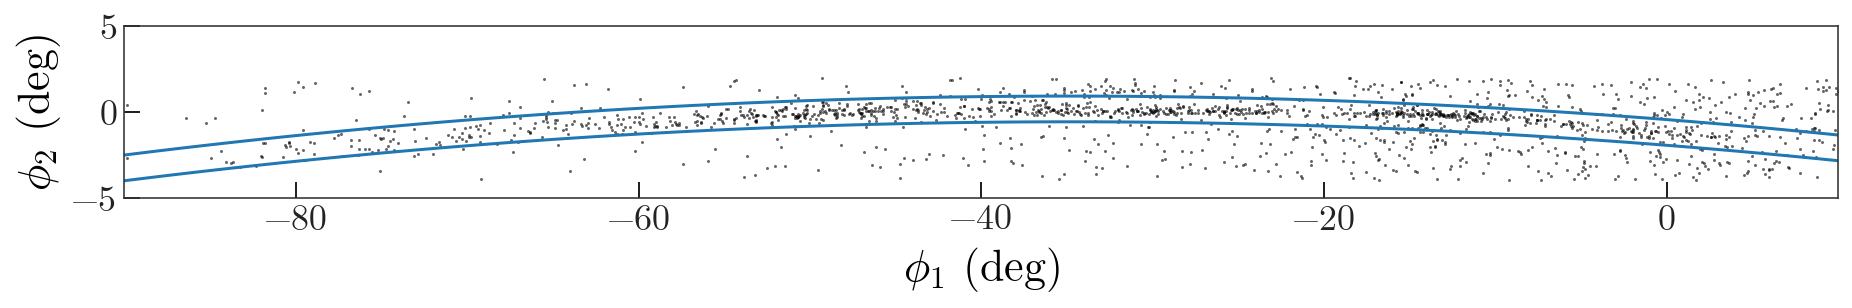

In [28]:
delta_phi2 = 0.75

plt.figure(figsize=(13,6))
plt.plot(gd1_c.phi1[phi2_wide_mask].wrap_at(180*u.deg), 
         gd1_c.phi2[phi2_wide_mask], 
         'ko', ms=1.5, alpha=0.6, rasterized=True)
plt.gca().set_aspect('equal')

plt.plot(phi1_, phi2_ + delta_phi2, '-', color='tab:blue')
plt.plot(phi1_, phi2_ - delta_phi2, '-', color='tab:blue')

plt.xlabel('$\phi_1$ (deg)')
plt.ylabel('$\phi_2$ (deg)')
plt.xlim(-90, 10)
plt.ylim(-5, 5)

plt.tight_layout()

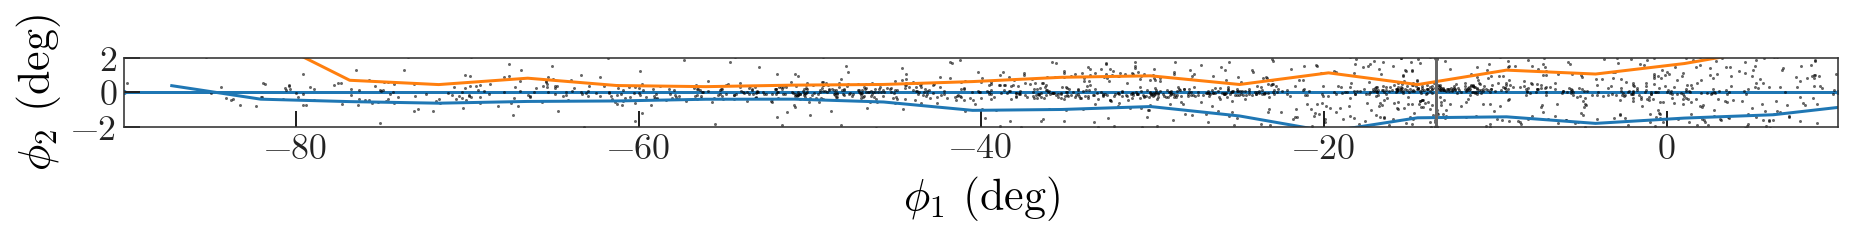

In [29]:
delta_phi2 = 0.75

plt.figure(figsize=(13,6))

_phi1 = gd1_c.phi1[phi2_wide_mask].wrap_at(180*u.deg).degree
dphi2 = gd1_c.phi2[phi2_wide_mask].degree - polytrack(_phi1)

res15 = binned_statistic(_phi1, dphi2, bins=25, 
                         statistic=lambda x: np.percentile(x, 15))
res85 = binned_statistic(_phi1, dphi2, bins=25,
                         statistic=lambda x: np.percentile(x, 85))

plt.plot(_phi1, dphi2,
         'ko', ms=1.5, alpha=0.6, rasterized=True)

plt.plot(0.5 * (res15.bin_edges[:-1] + res15.bin_edges[1:]), 
         res15.statistic, marker='')
plt.plot(0.5 * (res85.bin_edges[:-1] + res85.bin_edges[1:]), 
         res85.statistic, marker='')

plt.gca().set_aspect('equal')

plt.xlabel('$\phi_1$ (deg)')
plt.ylabel('$\phi_2$ (deg)')
plt.xlim(-90, 10)
plt.ylim(-2, 2)

plt.axhline(0., zorder=-10, color='tab:blue')
plt.axvline(-13.5)
plt.tight_layout()

In [30]:
def mad_std(x):
    """Median absolute deviation"""
    return 1.5 * np.median(np.abs(np.median(x)-x))

In [31]:
# delta_phi = 1
# window = 5
# off_phi2 = 2.5

# bins_phi1 = np.arange(-85-0.5*window, 10+0.5*window, delta_phi)
# Nbins = np.size(bins_phi1)

# n = np.zeros(Nbins)
# n_back = np.zeros(Nbins)
# w = np.zeros(Nbins)*u.deg
# rmed_phi2 = np.zeros(Nbins)*u.deg
# rmed_pmphi1 = np.zeros(Nbins)*u.mas/u.yr
# rmed_pmphi2 = np.zeros(Nbins)*u.mas/u.yr
# rmed_pmphi1_err = np.zeros(Nbins)*u.mas/u.yr
# rmed_pmphi2_err = np.zeros(Nbins)*u.mas/u.yr

# phi2_poly = polytrack(gd1_c.phi1[pm_mask & cmd_mask].wrap_at(180*u.deg))

# for i in range(Nbins):
#     sel_bin = ((gd1_c.phi1[pm_mask & cmd_mask].wrap_at(180*u.deg).to(u.deg).value>bins_phi1[i]-0.5*window) & 
#                  (gd1_c.phi1[pm_mask & cmd_mask].wrap_at(180*u.deg).to(u.deg).value<=bins_phi1[i]+0.5*window))
#     sel_stream = (np.abs(gd1_c.phi2[pm_mask & cmd_mask].to(u.deg).value - phi2_poly)<delta_phi2)
#     sel_back = ((np.abs(gd1_c.phi2[pm_mask & cmd_mask].to(u.deg).value - phi2_poly - off_phi2)<delta_phi2) |
#                 (np.abs(gd1_c.phi2[pm_mask & cmd_mask].to(u.deg).value - phi2_poly + off_phi2)<delta_phi2))
#     selection = sel_bin & sel_stream
    
#     n[i] = np.sum(selection)
#     n_back[i] = np.sum(sel_bin & sel_back) * 0.5
    
#     rmed_phi2[i] = np.nanmedian(gd1_c.phi2[pm_mask & cmd_mask][selection])
#     w[i] = mad_std(gd1_c.phi2[pm_mask & cmd_mask][selection])
    
#     rmed_pmphi1[i] = np.nanmedian(gd1_c_noreflex.pm_phi1_cosphi2[pm_mask & cmd_mask][selection])
#     rmed_pmphi1_err[i] = mad_std(gd1_c.pm_phi1_cosphi2[pm_mask & cmd_mask][selection])
    
#     rmed_pmphi2[i] = np.nanmedian(gd1_c_noreflex.pm_phi2[pm_mask & cmd_mask][selection])
#     rmed_pmphi2_err[i] = mad_std(gd1_c_noreflex.pm_phi2[pm_mask & cmd_mask][selection])

In [33]:
off_phi2 = 2.5

In [55]:
bin_size = 3 # deg
bin_l = np.arange(-90, (10-bin_size)+1, 1.)
bin_r = bin_l + bin_size
bins_phi1 = 0.5 * (bin_l+bin_r)

Nbins = len(bin_l)
n = np.zeros(Nbins)
n_back = np.zeros(Nbins)
w = np.zeros(Nbins)*u.deg
rmed_phi2 = np.zeros(Nbins)*u.deg
rmed_pmphi1 = np.zeros(Nbins)*u.mas/u.yr
rmed_pmphi2 = np.zeros(Nbins)*u.mas/u.yr
rmed_pmphi1_err = np.zeros(Nbins)*u.mas/u.yr
rmed_pmphi2_err = np.zeros(Nbins)*u.mas/u.yr

phi2_poly = polytrack(gd1_c.phi1[pm_mask & cmd_mask].wrap_at(180*u.deg))

_phi1 = gd1_c.phi1[pm_mask & cmd_mask].wrap_at(180*u.deg).degree
for i, l, r in zip(range(Nbins), bin_l, bin_r):
    sel_bin = (_phi1 > l) & (_phi1 <= r)
    sel_stream = (np.abs(gd1_c.phi2[pm_mask & cmd_mask].to(u.deg).value - phi2_poly) < delta_phi2)
    sel_back = ((np.abs(gd1_c.phi2[pm_mask & cmd_mask].to(u.deg).value - phi2_poly - off_phi2)<delta_phi2) |
                (np.abs(gd1_c.phi2[pm_mask & cmd_mask].to(u.deg).value - phi2_poly + off_phi2)<delta_phi2))
    selection = sel_bin & sel_stream
    
    n[i] = np.sum(selection)
    n_back[i] = np.sum(sel_bin & sel_back) * 0.5
    
    rmed_phi2[i] = np.nanmedian(gd1_c.phi2[pm_mask & cmd_mask][selection])
    w[i] = mad_std(gd1_c.phi2[pm_mask & cmd_mask][selection])
    
    rmed_pmphi1[i] = np.nanmedian(gd1_c_noreflex.pm_phi1_cosphi2[pm_mask & cmd_mask][selection])
    rmed_pmphi1_err[i] = mad_std(gd1_c.pm_phi1_cosphi2[pm_mask & cmd_mask][selection])
    
    rmed_pmphi2[i] = np.nanmedian(gd1_c_noreflex.pm_phi2[pm_mask & cmd_mask][selection])
    rmed_pmphi2_err[i] = mad_std(gd1_c_noreflex.pm_phi2[pm_mask & cmd_mask][selection])
    
density = (n-n_back)/(2*delta_phi2*bin_size)

/Users/adrian/anaconda/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1018: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/Users/adrian/anaconda/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/adrian/anaconda/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [157]:
# Write out the track properties:

# output table w track observables
ttrack = Table([bins_phi1, n, n_back, density, rmed_phi2, w, rmed_pmphi1, rmed_pmphi1_err, rmed_pmphi2, rmed_pmphi2_err],
              names=('phi1', 'n', 'n_back', 'density', 'phi2', 'w', 'pm_phi1_cosphi2', 'pm_phi1_cosphi2_error', 
                     'pm_phi2', 'pm_phi2_error'))
# skip 0th row because nan
ttrack[1:].write('../data/track.fits', overwrite=True)

Did orbit fit and stream model in `GD1-orbit-fit.ipynb`...

In [56]:
stream_w = np.load('../data/stream_model.npy')
stream = gd.PhaseSpacePosition(pos=stream_w[:, :3].T*u.kpc,
                               vel=stream_w[:, 3:].T*u.km/u.s)
gc_frame = coord.Galactocentric(galcen_distance=8*u.kpc, z_sun=0*u.pc)

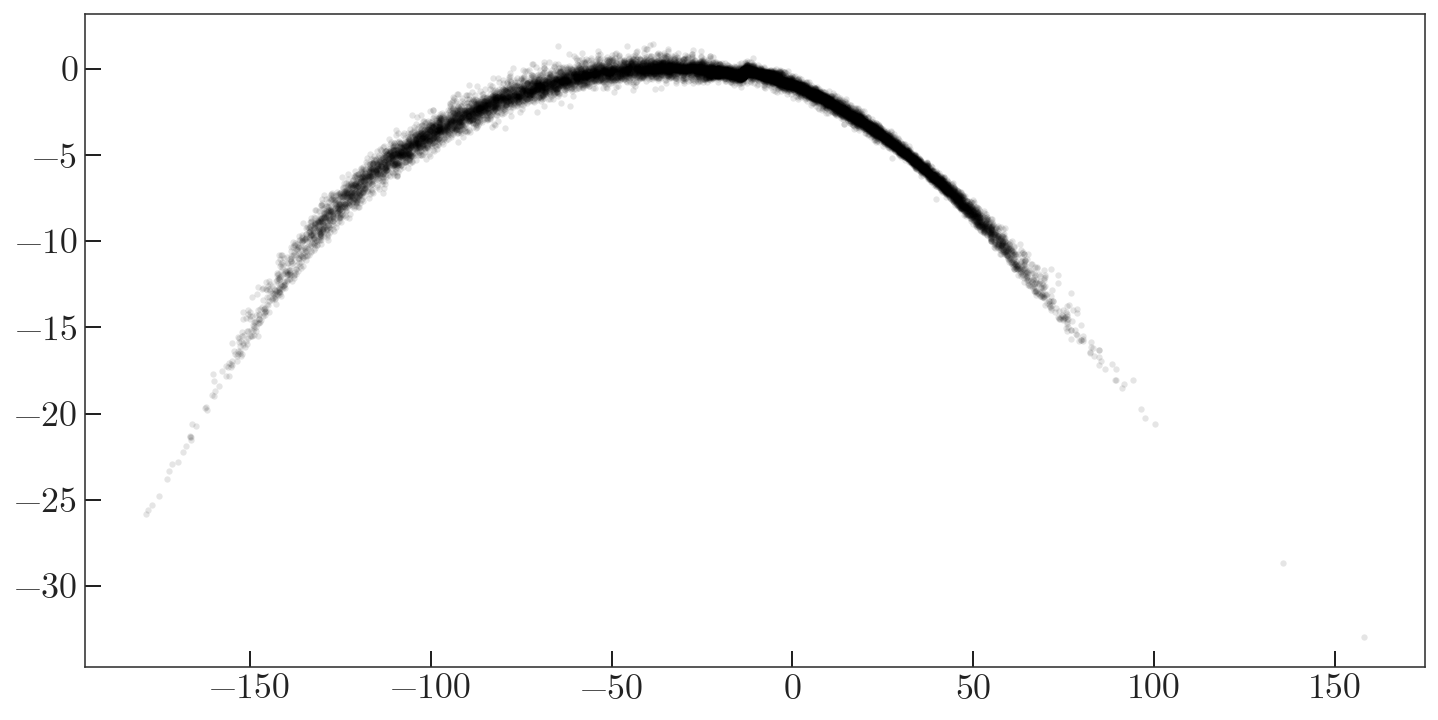

In [57]:
stream_gd1 = stream.to_coord_frame(gc.GD1, galactocentric_frame=gc_frame)

fig, ax = plt.subplots(1, 1, figsize=(12, 6))
_x = stream_gd1.phi1.wrap_at(180*u.deg).degree
ax.scatter(_x, stream_gd1.phi2.degree, 
           alpha=0.1, linewidth=0, s=10, c='k', zorder=-100)

In [58]:
Nbins = len(bin_l)
model_n = np.zeros(Nbins)
model_w = np.zeros(Nbins)*u.deg
model_rmed_phi2 = np.zeros(Nbins)*u.deg
model_rmed_pmphi1 = np.zeros(Nbins)*u.mas/u.yr
model_rmed_pmphi2 = np.zeros(Nbins)*u.mas/u.yr
model_rmed_pmphi1_err = np.zeros(Nbins)*u.mas/u.yr
model_rmed_pmphi2_err = np.zeros(Nbins)*u.mas/u.yr

_phi1 = stream_gd1.phi1.wrap_at(180*u.deg).degree
for i, l, r in zip(range(Nbins), bin_l, bin_r):
    sel_bin = (_phi1 > l) & (_phi1 <= r)
    sel_stream = (np.abs(stream_gd1.phi2.to(u.deg).value) < 3.)
    selection = sel_bin & sel_stream
    
    model_n[i] = np.sum(selection)
    model_rmed_phi2[i] = np.nanmedian(stream_gd1.phi2[selection])
    model_w[i] = mad_std(stream_gd1.phi2[selection])
    
    model_rmed_pmphi1[i] = np.nanmedian(stream_gd1.pm_phi1_cosphi2[selection])
    model_rmed_pmphi1_err[i] = mad_std(stream_gd1.pm_phi1_cosphi2[selection])
    
    model_rmed_pmphi2[i] = np.nanmedian(stream_gd1.pm_phi2[selection])
    model_rmed_pmphi2_err[i] = mad_std(stream_gd1.pm_phi2[selection])
    
model_density = model_n / (2*delta_phi2*bin_size)
model_density = model_density / model_density.max() * density.max()

/Users/adrian/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:48: RuntimeWarning: divide by zero encountered in true_divide


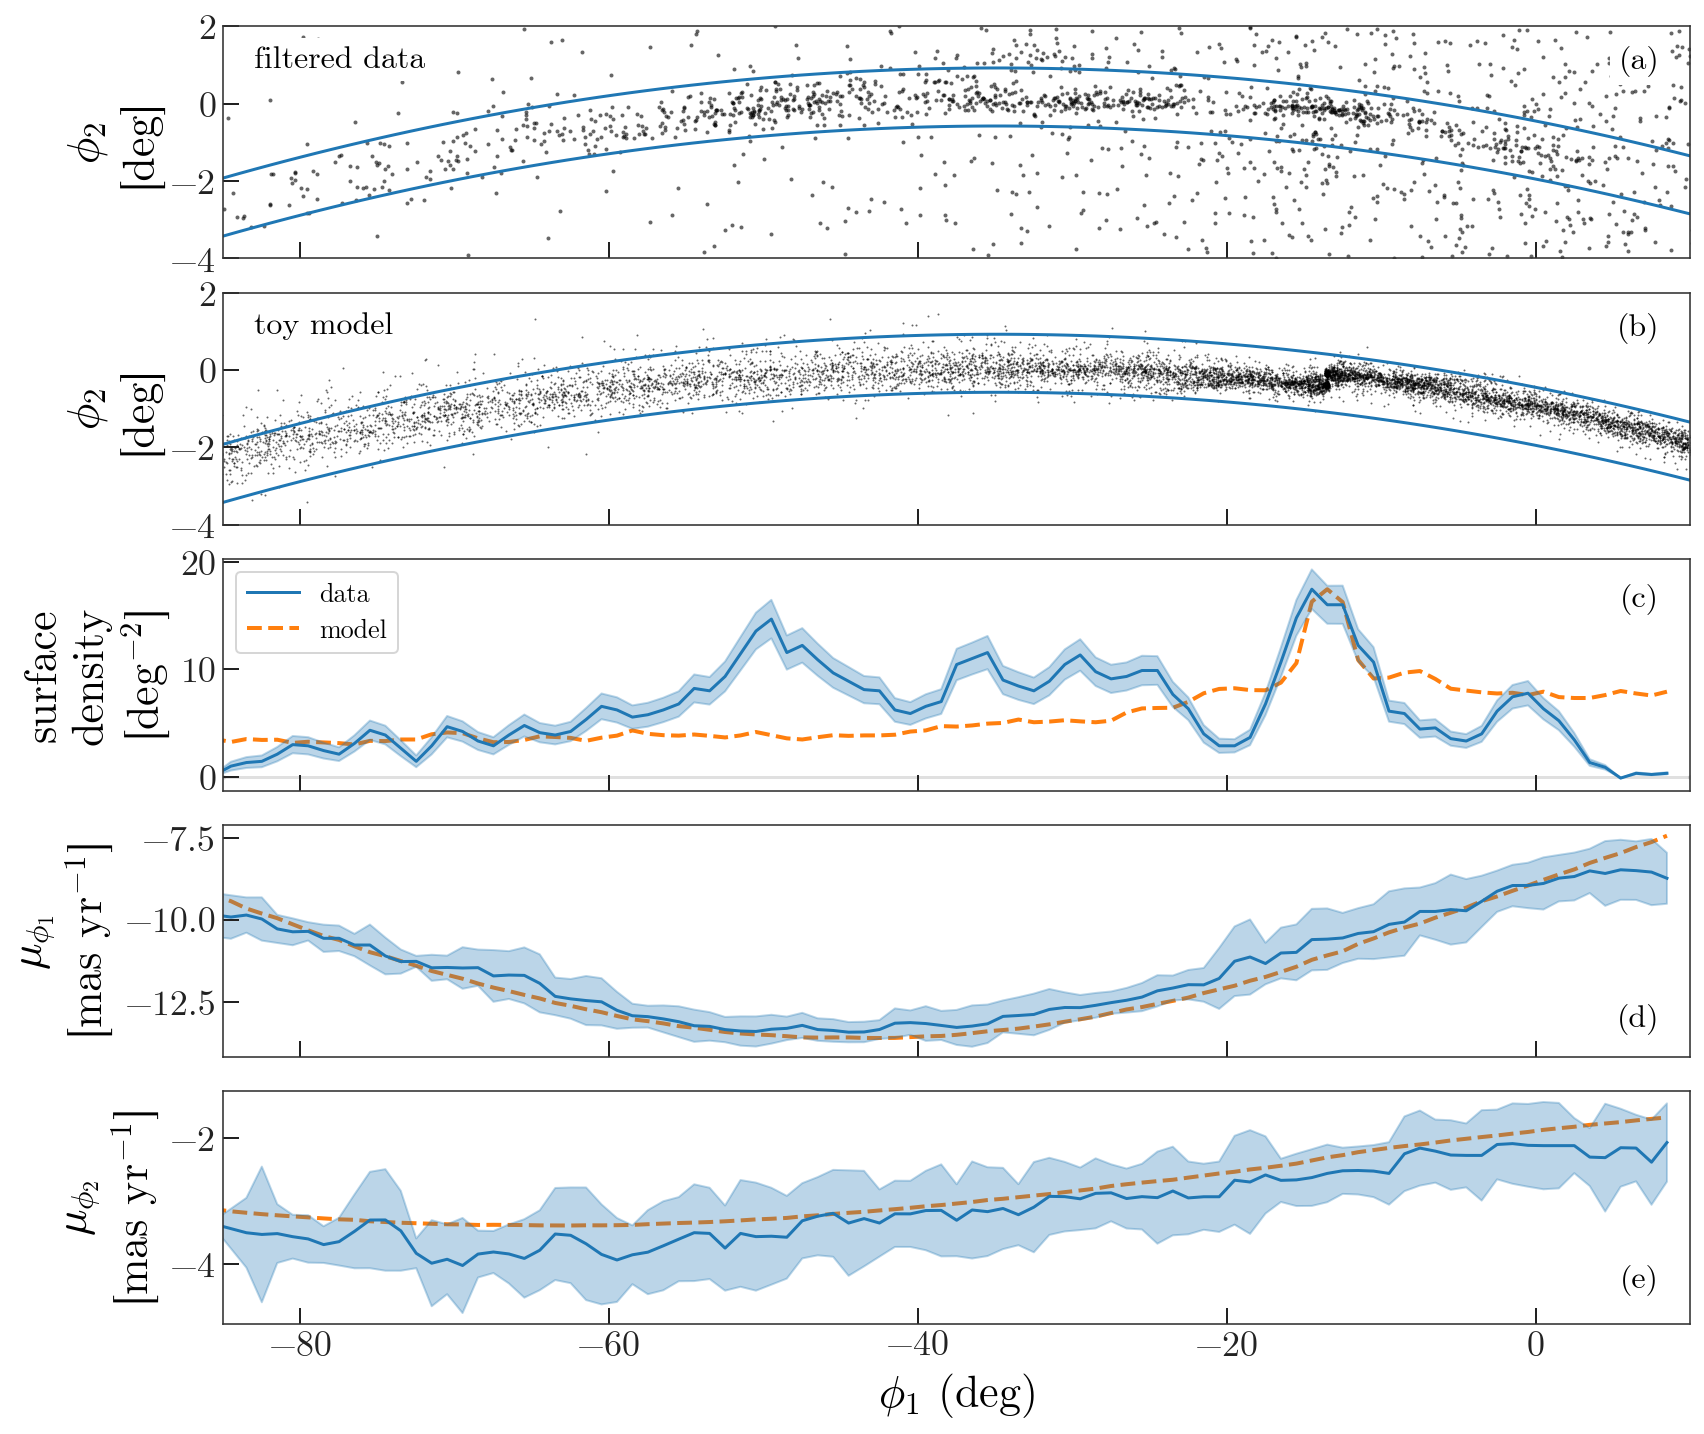

In [84]:
fig, axes = plt.subplots(5, 1, figsize=(12,10), sharex=True)

ax = axes[0]
ax.plot(gd1_c.phi1[phi2_wide_mask].wrap_at(wangle), 
        gd1_c.phi2[phi2_wide_mask], 
        'ko', ms=2, alpha=0.6, rasterized=True)

ax.plot(phi1_, phi2_+delta_phi2, '-', color='tab:blue')
ax.plot(phi1_, phi2_-delta_phi2, '-', color='tab:blue')
ax.text(-83, 1.5, 'filtered data', ha='left', va='top', 
        bbox=dict(facecolor='w', alpha=1), fontsize=16)
ax.set_ylabel('$\phi_2$\n[deg]')
ax.set_ylim(-4, 2)

ax.text(8, 1.5, '(a)', ha='right', va='top', 
        bbox=dict(facecolor='w', alpha=1), fontsize=16)

# phi2 track:
# ax = axes[1]
# ax.plot(bins_phi1, rmed_phi2, '-')
# ax.fill_between(bins_phi1, rmed_phi2-w, rmed_phi2+w, 
#                 color='tab:blue', alpha=0.3)

# ax.plot(bins_phi1, model_rmed_phi2, '--', color='tab:orange', zorder=-10, lw=2)

# ax.set_ylabel('$\phi_2$\n[deg]')

# model stream
ax = axes[1]
ax.plot(stream_gd1.phi1.wrap_at(wangle), 
        stream_gd1.phi2, 
        marker='o', linestyle='none', ms=1., color='k', 
        alpha=0.6, rasterized=True)

ax.plot(phi1_, phi2_+delta_phi2, '-', color='tab:blue')
ax.plot(phi1_, phi2_-delta_phi2, '-', color='tab:blue')
ax.text(-83, 1.5, 'toy model', ha='left', va='top', 
        bbox=dict(facecolor='w', alpha=1), fontsize=16)

ax.text(8, 1.5, '(b)', ha='right', va='top', 
        bbox=dict(facecolor='w', alpha=1), fontsize=16)

ax.set_ylabel('$\phi_2$\n[deg]')
ax.set_ylim(-4, 2)

ax = axes[2]
ax.plot(bins_phi1, density, '-', label='data')
ax.fill_between(bins_phi1, density*(1-1/np.sqrt(n)), density*(1+1/np.sqrt(n)), 
                color='tab:blue', alpha=0.3)
ax.axhline(0, zorder=-10, alpha=0.2)

ax.plot(bins_phi1, model_density, '--', 
        color='tab:orange', zorder=-10, lw=2, label='model')
ax.legend(loc='upper left', fontsize=13)

ax.set_ylabel('surface\ndensity\n[deg$^{-2}$]')

ax.text(8, 18, '(c)', ha='right', va='top', 
        bbox=dict(facecolor='w', alpha=1), fontsize=16)

ax = axes[3]
ax.plot(bins_phi1, rmed_pmphi1, '-')
ax.fill_between(bins_phi1, rmed_pmphi1-rmed_pmphi1_err, rmed_pmphi1+rmed_pmphi1_err, 
                color='tab:blue', alpha=0.3)

ax.plot(bins_phi1, model_rmed_pmphi1, '--', 
        color='tab:orange', zorder=-10, lw=2)

ax.set_ylabel('$\mu_{\phi_1}$\n[mas yr$^{-1}$]')

ax.text(8, -13.5, '(d)', ha='right', va='bottom', 
        bbox=dict(facecolor='w', alpha=1), fontsize=16)

ax = axes[4]
ax.plot(bins_phi1, rmed_pmphi2, '-')
ax.fill_between(bins_phi1, rmed_pmphi2-rmed_pmphi2_err, rmed_pmphi2+rmed_pmphi2_err, 
                color='tab:blue', alpha=0.3)

ax.plot(bins_phi1, model_rmed_pmphi2, '--', color='tab:orange', zorder=-10, lw=2)

ax.set_xlabel('$\phi_1$ (deg)')
ax.set_ylabel('$\mu_{\phi_2}$\n[mas yr$^{-1}$]')

ax.text(8, -4.5, '(e)', ha='right', va='bottom', 
        bbox=dict(facecolor='w', alpha=1), fontsize=16)

axes[0].set_xlim(-85, 10)

fig.tight_layout()
fig.savefig('../paper/track_observables.pdf')

## Estimate surface density variations from scanning law:

/Users/adrian/anaconda/lib/python3.6/site-packages/astropy/units/quantity.py:639: RuntimeWarning: invalid value encountered in less
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/adrian/anaconda/lib/python3.6/site-packages/astropy/units/quantity.py:639: RuntimeWarning: invalid value encountered in greater
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


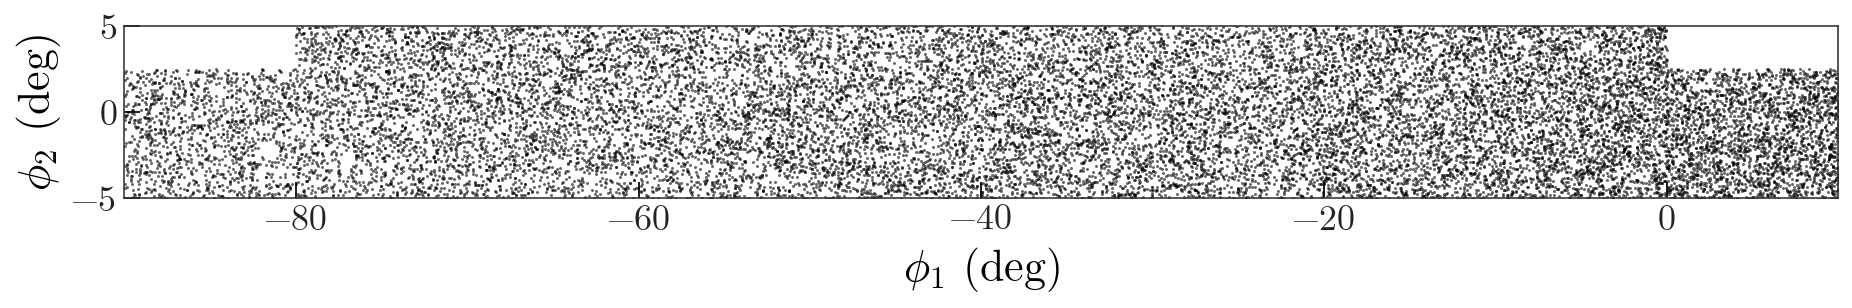

In [90]:
pm_mask_off = ((gd1_c.pm_phi1_cosphi2 < -5*u.mas/u.yr) & (gd1_c.pm_phi1_cosphi2 > -10*u.mas/u.yr) & 
               (gd1_c.pm_phi2 < 5*u.mas/u.yr) & (gd1_c.pm_phi2 > 1*u.mas/u.yr) & 
               (g.bp_rp < 1.5*u.mag) & (g.bp_rp > 0*u.mag))

plt.figure(figsize=(13,6))
plt.plot(gd1_c.phi1[pm_mask_off].wrap_at(180*u.deg), 
         gd1_c.phi2[pm_mask_off], 
         'ko', ms=1.5, alpha=0.6, rasterized=True)
plt.gca().set_aspect('equal')

plt.xlabel('$\phi_1$ (deg)')
plt.ylabel('$\phi_2$ (deg)')
plt.xlim(-90, 10)
plt.ylim(-5, 5)

plt.tight_layout()

In [96]:
n_scanny = np.zeros(Nbins)

_phi1 = gd1_c.phi1[pm_mask_off & cmd_mask].wrap_at(180*u.deg).degree
phi2_poly_off = polytrack(gd1_c.phi1[pm_mask_off & cmd_mask].wrap_at(180*u.deg))

for i, l, r in zip(range(Nbins), bin_l, bin_r):
    sel_bin = (_phi1 > l) & (_phi1 <= r)
    sel_stream = (np.abs(gd1_c.phi2[pm_mask_off & cmd_mask].to(u.deg).value - phi2_poly_off) < delta_phi2)
    selection = sel_bin & sel_stream
    
    n_scanny[i] = np.sum(selection)
    
density_scanny = n_scanny / (2*delta_phi2*bin_size)

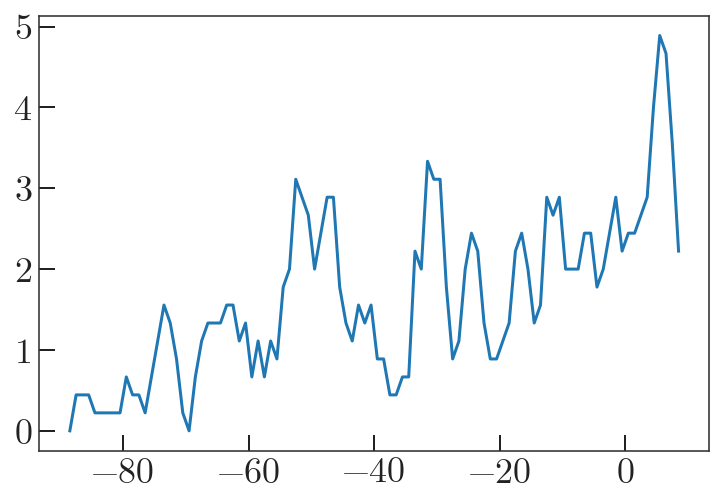

In [97]:
plt.plot(bins_phi1, density_scanny, '-')

In [98]:
np.std(density_scanny)

1.0289988593866477

---